In the testing of collection 3 WOfS, it was noticed that seasonal effects (presumably terrain shadow, or possibly snow oversaturation) had been relabelled from nodata to noncontiguity. Also, diffuse nodata (possibly cloud oversaturation) was reduced in collection 3. This notebook is to confirm whether these effects exist in the source ARD data or are due to mistakes in WOFL processing.

In [36]:
import datacube, matplotlib.pyplot as plt, matplotlib.colors, numpy as np

In [2]:
dc = datacube.Datacube()

In [3]:
lat, lon = -41.8, 146 # Tasmania, mountainous area
e = 0.1

In [151]:
ard = dc.load(product='ga_ls7e_ard_3', lat=(lat-e, lat+e), lon=(lon-e,lon+e), time=('2000-06'), output_crs='epsg:3577', resolution=(25,-25))
wofs2 = dc.load(product='wofs_albers', lat=(lat-e, lat+e), lon=(lon-e,lon+e), time=('2000-06'), output_crs='epsg:3577', resolution=(25,-25))
wofs3 = dc.load(product='ga_ls_wofs_3', lat=(lat-e, lat+e), lon=(lon-e,lon+e), time=('2000-06'), output_crs='epsg:3577', resolution=(25,-25))

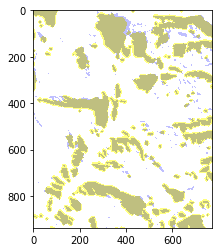

In [82]:
# Collection 3
plt.imshow(wofs3.water.data[0] & 1, cmap=matplotlib.colors.ListedColormap(['white', 'red']), alpha=1) # red = nodata
plt.imshow(wofs3.water.data[0] & 2, cmap=matplotlib.colors.ListedColormap(['white', 'blue']), alpha=0.5) # blue = noncontiguity
plt.imshow(wofs3.water.data[0] & 8, cmap=matplotlib.colors.ListedColormap(['white', 'yellow']), alpha=0.5) # yellow = terrain

# Evidently, there is noncontiguity that mostly overlaps the wofs terrain mask, but is not marked nodata.

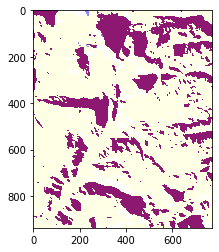

In [89]:
# Collection 2
plt.imshow(wofs2.water.data[0] & 1, cmap=matplotlib.colors.ListedColormap(['white', 'red']), alpha=1) # red = nodata
plt.imshow(wofs2.water.data[0] & 2, cmap=matplotlib.colors.ListedColormap(['white', 'blue']), alpha=0.5) # blue = noncontiguity
plt.imshow(wofs2.water.data[0] & 8, cmap=matplotlib.colors.ListedColormap(['white', 'yellow']), alpha=0.1) # yellow = terrain

# Here, it is mostly marked nodata and noncontiguous and terrain. 
# (Indeed, nodata always also implies noncontiguity, by the original definitions of all vs any bands lacking data.)

# The question is, why is it not also marked nodata in collection 3?

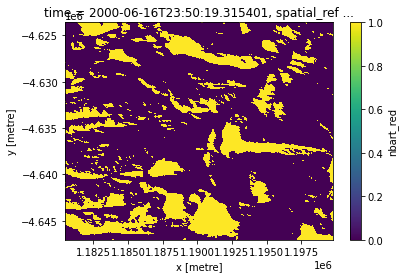

In [94]:
(ard.nbart_red == ard.nbart_red.nodata).plot()

In [110]:
for name in ard.variables:
    if not set(ard[name].dims) ^ set(['x', 'y', 'time']): # Consider all raster bands,
        print('%.3f' % (ard[name] == ard[name].nodata).data.mean(), name) # What portion is nodata respectively?

0.228 nbart_blue
0.228 nbart_green
0.228 nbart_red
0.228 nbart_nir
0.228 nbart_swir_1
0.228 nbart_swir_2
0.281 nbart_panchromatic
0.000 oa_fmask
0.000 oa_nbart_contiguity
0.000 oa_azimuthal_exiting
0.000 oa_azimuthal_incident
0.000 oa_combined_terrain_shadow
0.000 oa_exiting_angle
0.000 oa_incident_angle
0.000 oa_relative_azimuth
0.000 oa_relative_slope
0.000 oa_satellite_azimuth
0.000 oa_satellite_view
0.000 oa_solar_azimuth
0.000 oa_solar_zenith
0.000 oa_time_delta


In [118]:
(~ard['oa_nbart_contiguity'].data.astype(np.bool)).mean()

0.22845116498453952

In [122]:
(wofs2.water.data & 3).astype(np.bool).mean(), (wofs3.water.data & 3).astype(np.bool).mean()

(0.2387521825358515, 0.22845116498453952)

In [133]:
# It appears that the wofs3 noncontiguity is consistent with the first six ARD (collection 3) bands.
# So, why isn't it flagged as nodata in wofs3?

([-999, -999, -999, -999, -999, -999, -999], 7)

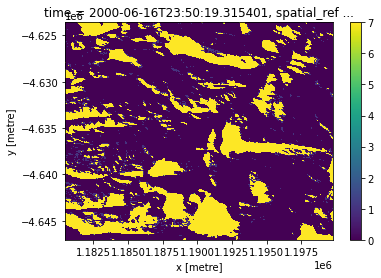

In [146]:
# All 6+ ARD bands seem spatially consistent regards nodata. Even consistent regards nodata value.

bands = ['nbart_' + band for band in ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'panchromatic']] # even including panchromatic

sum([ard[name] == ard[name].nodata for name in bands]).plot()

[ard[name].nodata for name in bands], len(bands)

In [149]:
(wofs2.water & 1).data.mean(), (wofs3.water & 1).data.mean() # Nothing at all in this area is tagged nodata in wofs collection 3.

(0.23764608853717, 0.0)

In [154]:
# Next question, does anything ever get flagged nodata in wofs collection 3? 

# Note, a sensible redefinition of nodata (given the availability of the noncontig field) 
# might be to only flag areas outside the scene boundary.

big_wofs3 = dc.load(datasets=dc.find_datasets(product='ga_ls_wofs_3', lat=(lat-e, lat+e), lon=(lon-e,lon+e), time=('2000-06')), 
                    output_crs='epsg:3577', resolution=(25,-25))

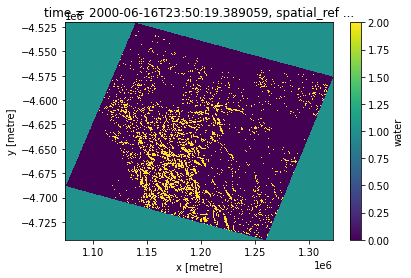

In [156]:
(big_wofs3.water[:,::10, ::10] & 3).plot() # yes: nodata outside extent; neither (good) or noncontig (bad) inside of extent.

In [161]:
# Regards implementation, might this be because the ARD fmask band is now included in the check for whether ALL (vs any) bands are nodata?

big_ard = dc.load(datasets=dc.find_datasets(product='ga_ls7e_ard_3', lat=(lat-e, lat+e), lon=(lon-e,lon+e), time=('2000-06')), 
                    output_crs='epsg:3577', resolution=(25,-25), measurements=['oa_fmask'])

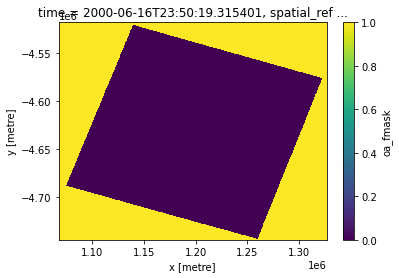

In [165]:
(big_ard.oa_fmask[:,::10, ::10] == big_ard.oa_fmask.nodata).plot() # yes, plausible explanation.